In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [3]:
df_b7_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44009_clean.csv')
df_b8_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44065_clean.csv')

In [3]:
def plot_df(df, x,y1, y2, title="", xlabel='Date', dpi=100):
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y1)
    ax1.set_ylabel('Windspeed')
    #plt.setp(fig, rotation=90)
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel('Pressure', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

In [6]:

keep_col = ['day','month','datetime','waveperiod','waveheight','WindDir','windspeed','pressure','possibility','hurrthreat']
df_b7 = df_b7_init[keep_col]
df_b8=df_b8_init[keep_col]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



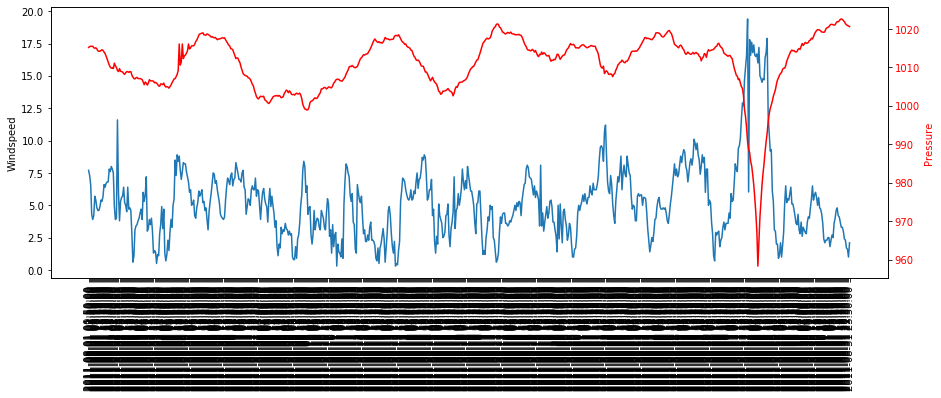

In [5]:
rs_09 = df_b7.loc[ (df_b7['month']==8)] #& ( (df_b7['day']==27) | (df_b7['day']==28) | (df_b7['day']==29) )]rs_09['date'] = rs_09['datetime'].astype('datetime64[ns]')
rs_09['date'] = rs_09['datetime'].astype('datetime64[ns]')
rs_09.head()
plot_df(rs_09, x=rs_09.datetime,y1=rs_09.windspeed, y2=rs_09.pressure, title='Pressure in month of August')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



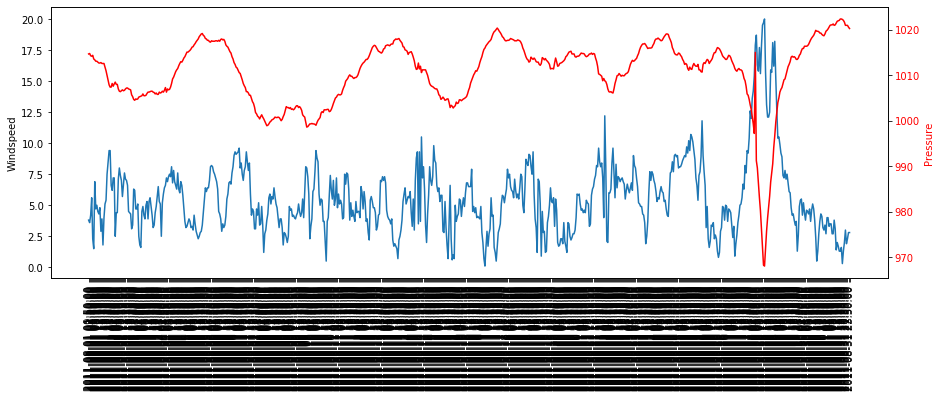

In [6]:
rs_65 = df_b8.loc[ (df_b8['month']==8)]# & ( (df_b8['day']==27) | (df_b8['day']==28) | (df_b8['day']==29) )]
rs_65['date'] = rs_65['datetime'].astype('datetime64[ns]')
rs_65.head()
plot_df(rs_65, x=rs_65.datetime,y1=rs_65.windspeed, y2=rs_65.pressure, title='Pressure in month of August')

Text(0, 0.5, 'pressure')

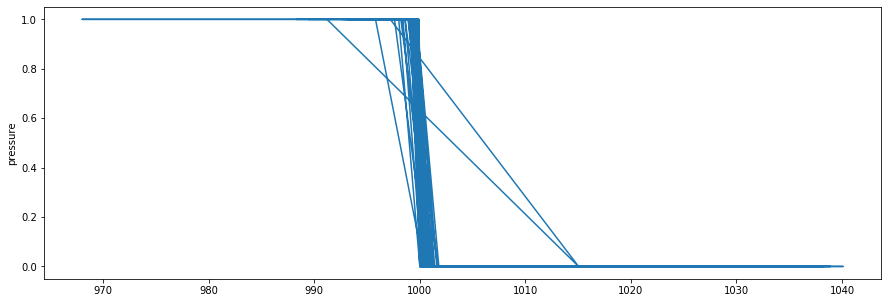

In [8]:
x=df_b7['pressure']
y1=df_b7['possibility']
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('pressure')

In [10]:
keep_col = ['day','month','waveperiod','waveheight','WindDir','windspeed','pressure']
X = df_b7[keep_col]
y = df_b7['possibility']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['possibility'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['possibility']==0]))
print("Number of subscription",len(os_data_y[os_data_y['possibility']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['possibility']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['possibility']==1])/len(os_data_X))

length of oversampled data is  10744
Number of no subscription in oversampled data 5372
Number of subscription 5372
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [11]:
os_data_X


,day,month,waveperiod,waveheight,WindDir,windspeed,pressure
0,26.000000,6.000000,5.440000,0.790000,262.000000,2.500000,1011.500000
1,21.000000,8.000000,4.570000,0.780000,187.000000,4.600000,1014.900000
2,9.000000,11.000000,7.700000,0.920000,139.000000,2.400000,1020.700000
3,13.000000,8.000000,4.570000,0.430000,299.000000,2.200000,1016.900000
4,1.000000,3.000000,3.850000,1.030000,345.000000,8.900000,1023.800000
...,...,...,...,...,...,...,...
10739,14.696704,9.878682,4.541543,1.519965,240.636045,8.842111,999.206066
10740,24.000000,3.000000,5.237680,1.921520,35.911708,9.391992,999.469610
10741,18.359586,1.000000,4.103710,0.883130,321.609326,6.882902,998.054715
10742,19.000000,10.000000,8.987763,8.977212,64.000000,11.894944,999.096292


In [12]:
os_data_y.head()

,possibility
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [13]:
keep_col = ['windspeed','pressure']
df_b7_logit = os_data_X[keep_col]
y1=os_data_y['possibility']


In [14]:
X_train, x_test, y_train, y_test = train_test_split(df_b7_logit,y1,test_size=0.3, random_state=0)

In [15]:
logreg = LogisticRegression()

#logit_model=sm.Logit(y_train,X_train.astype(float))

result=logreg.fit(X_train,y_train)
#print(result.summary2())

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [16]:
#keep_col_new=['pressure']
#new_x= df_b7_init[keep_col_new]
#y1=df_b7_init['hurrthreat']
#X_t, X_tes, y_t, y_tes = train_test_split(new_x, y1, test_size=0.3, random_state=0)

#model.fit(X_t, y_t)
y_pred = logreg.predict(x_test)
x_test.head()
#X_tes.iloc[3]
for i in range(len(x_test)):
    if(y_pred[i]==1):
        print("%s, Predicted=%s" % (x_test.iloc[i], y_pred[i]))

windspeed      12.0
pressure     1025.3
Name: 597, dtype: float64, Predicted=1.0
windspeed       9.2
pressure     1011.6
Name: 4798, dtype: float64, Predicted=1.0
windspeed       9.5
pressure     1013.7
Name: 2457, dtype: float64, Predicted=1.0
windspeed      7.262727
pressure     994.386970
Name: 5721, dtype: float64, Predicted=1.0
windspeed     13.327421
pressure     997.647841
Name: 8662, dtype: float64, Predicted=1.0
windspeed      9.982797
pressure     998.908280
Name: 6012, dtype: float64, Predicted=1.0
windspeed      7.8
pressure     995.4
Name: 5211, dtype: float64, Predicted=1.0
windspeed     10.415907
pressure     997.200000
Name: 10440, dtype: float64, Predicted=1.0
windspeed      9.938692
pressure     996.967178
Name: 5765, dtype: float64, Predicted=1.0
windspeed     12.249441
pressure     998.199681
Name: 9126, dtype: float64, Predicted=1.0
windspeed     11.708358
pressure     993.859674
Name: 7722, dtype: float64, Predicted=1.0
windspeed      8.784148
pressure     997.879

Name: 8376, dtype: float64, Predicted=1.0
windspeed      7.300000
pressure     994.326636
Name: 7565, dtype: float64, Predicted=1.0
windspeed     11.536181
pressure     998.883803
Name: 6402, dtype: float64, Predicted=1.0
windspeed      9.322300
pressure     999.590606
Name: 6183, dtype: float64, Predicted=1.0
windspeed     10.919021
pressure     995.413783
Name: 9949, dtype: float64, Predicted=1.0
windspeed     10.046308
pressure     997.646057
Name: 10222, dtype: float64, Predicted=1.0
windspeed      7.642703
pressure     994.977067
Name: 9459, dtype: float64, Predicted=1.0
windspeed     10.853879
pressure     997.927221
Name: 8463, dtype: float64, Predicted=1.0
windspeed      9.403071
pressure     998.861549
Name: 7057, dtype: float64, Predicted=1.0
windspeed      8.855409
pressure     998.151375
Name: 9058, dtype: float64, Predicted=1.0
windspeed      12.0
pressure     1025.2
Name: 4958, dtype: float64, Predicted=1.0
windspeed     11.004645
pressure     998.271048
Name: 7811, dtype

Name: 377, dtype: float64, Predicted=1.0
windspeed      7.717005
pressure     996.332877
Name: 6860, dtype: float64, Predicted=1.0
windspeed      13.9
pressure     1019.1
Name: 4381, dtype: float64, Predicted=1.0
windspeed     11.639023
pressure     997.357425
Name: 7071, dtype: float64, Predicted=1.0
windspeed     13.404318
pressure     997.511510
Name: 6954, dtype: float64, Predicted=1.0
windspeed     12.651632
pressure     997.628105
Name: 9967, dtype: float64, Predicted=1.0
windspeed     12.598463
pressure     997.206915
Name: 7744, dtype: float64, Predicted=1.0
windspeed     14.020349
pressure     996.676629
Name: 7055, dtype: float64, Predicted=1.0
windspeed     12.201159
pressure     997.077177
Name: 9033, dtype: float64, Predicted=1.0
windspeed       9.7
pressure     1019.8
Name: 1167, dtype: float64, Predicted=1.0
windspeed     10.351450
pressure     996.200644
Name: 9942, dtype: float64, Predicted=1.0
windspeed     14.105418
pressure     997.060803
Name: 7920, dtype: float64,

windspeed      9.317727
pressure     994.034776
Name: 7923, dtype: float64, Predicted=1.0
windspeed      7.650959
pressure     992.768920
Name: 9093, dtype: float64, Predicted=1.0
windspeed      11.4
pressure     1009.5
Name: 4365, dtype: float64, Predicted=1.0
windspeed      8.048701
pressure     998.971541
Name: 7106, dtype: float64, Predicted=1.0
windspeed     10.450728
pressure     997.366182
Name: 6210, dtype: float64, Predicted=1.0
windspeed      8.028453
pressure     994.900276
Name: 6639, dtype: float64, Predicted=1.0
windspeed     10.119433
pressure     997.320850
Name: 8598, dtype: float64, Predicted=1.0
windspeed      8.131949
pressure     995.355594
Name: 9426, dtype: float64, Predicted=1.0
windspeed     11.837051
pressure     998.222308
Name: 9074, dtype: float64, Predicted=1.0
windspeed     13.655548
pressure     981.811023
Name: 5953, dtype: float64, Predicted=1.0
windspeed     13.397304
pressure     999.117573
Name: 6986, dtype: float64, Predicted=1.0
windspeed      9.4

windspeed      7.186154
pressure     995.839970
Name: 8418, dtype: float64, Predicted=1.0
windspeed      7.218328
pressure     996.129766
Name: 9540, dtype: float64, Predicted=1.0
windspeed      10.7
pressure     1016.4
Name: 2400, dtype: float64, Predicted=1.0
windspeed     12.539527
pressure     997.472127
Name: 6849, dtype: float64, Predicted=1.0
windspeed      9.818529
pressure     999.038365
Name: 10535, dtype: float64, Predicted=1.0
windspeed     15.878356
pressure     994.474521
Name: 8899, dtype: float64, Predicted=1.0
windspeed      13.3
pressure     1005.4
Name: 1380, dtype: float64, Predicted=1.0
windspeed     12.646153
pressure     998.346153
Name: 8188, dtype: float64, Predicted=1.0
windspeed     14.299789
pressure     990.500932
Name: 10424, dtype: float64, Predicted=1.0
windspeed     13.770536
pressure     995.727678
Name: 5972, dtype: float64, Predicted=1.0
windspeed     10.690999
pressure     997.931751
Name: 7256, dtype: float64, Predicted=1.0
windspeed     14.167661


Name: 5338, dtype: float64, Predicted=1.0
windspeed     12.810474
pressure     995.962843
Name: 8137, dtype: float64, Predicted=1.0
windspeed      7.410740
pressure     994.543629
Name: 8202, dtype: float64, Predicted=1.0
windspeed      9.675368
pressure     997.551915
Name: 9469, dtype: float64, Predicted=1.0
windspeed     13.005126
pressure     997.527107
Name: 6254, dtype: float64, Predicted=1.0
windspeed     11.817798
pressure     997.164404
Name: 10434, dtype: float64, Predicted=1.0
windspeed     11.890993
pressure     997.941147
Name: 8160, dtype: float64, Predicted=1.0
windspeed     13.042270
pressure     982.973939
Name: 6476, dtype: float64, Predicted=1.0
windspeed      8.094621
pressure     995.209282
Name: 6853, dtype: float64, Predicted=1.0
windspeed     12.726292
pressure     995.049778
Name: 9068, dtype: float64, Predicted=1.0
windspeed     14.810400
pressure     999.504094
Name: 9223, dtype: float64, Predicted=1.0
windspeed      8.287505
pressure     995.824199
Name: 660

windspeed     11.520990
pressure     996.028048
Name: 10191, dtype: float64, Predicted=1.0
windspeed      9.278314
pressure     995.643371
Name: 10065, dtype: float64, Predicted=1.0
windspeed     11.778634
pressure     997.242732
Name: 8721, dtype: float64, Predicted=1.0
windspeed      8.319346
pressure     998.059673
Name: 7383, dtype: float64, Predicted=1.0
windspeed     11.723911
pressure     998.944563
Name: 10553, dtype: float64, Predicted=1.0
windspeed      9.240178
pressure     997.753588
Name: 9300, dtype: float64, Predicted=1.0
windspeed     12.076833
pressure     998.870485
Name: 9176, dtype: float64, Predicted=1.0
windspeed     12.630143
pressure     998.141049
Name: 8464, dtype: float64, Predicted=1.0
windspeed      10.5
pressure     1007.8
Name: 1675, dtype: float64, Predicted=1.0
windspeed      8.738124
pressure     999.594199
Name: 9269, dtype: float64, Predicted=1.0
windspeed     12.556817
pressure     997.394325
Name: 5842, dtype: float64, Predicted=1.0
windspeed     1

In [17]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


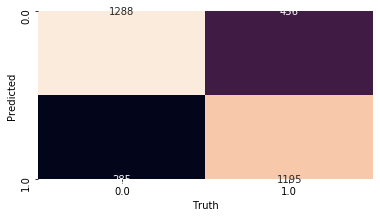

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

In [19]:
df_b8_logit = df_b8_init[keep_col]
y2=df_b8_init['possibility']

In [20]:
y_pred2 = logreg.predict(df_b8_logit)
for i in range(len(df_b8_logit)):
    if(df_b8_logit.iloc[i]['pressure']<1000):
        print("%s, Predicted=%s" % (df_b8_logit.iloc[i], y_pred2[i]))

windspeed      2.6
pressure     999.6
Name: 152, dtype: float64, Predicted=0.0
windspeed      2.5
pressure     999.0
Name: 153, dtype: float64, Predicted=0.0
windspeed      3.7
pressure     998.6
Name: 154, dtype: float64, Predicted=0.0
windspeed      4.3
pressure     998.1
Name: 155, dtype: float64, Predicted=0.0
windspeed      4.9
pressure     997.8
Name: 156, dtype: float64, Predicted=0.0
windspeed      5.0
pressure     997.3
Name: 157, dtype: float64, Predicted=0.0
windspeed      5.4
pressure     997.0
Name: 158, dtype: float64, Predicted=0.0
windspeed      6.7
pressure     996.5
Name: 159, dtype: float64, Predicted=0.0
windspeed      6.9
pressure     995.7
Name: 160, dtype: float64, Predicted=0.0
windspeed      7.3
pressure     994.9
Name: 161, dtype: float64, Predicted=1.0
windspeed      4.4
pressure     994.2
Name: 162, dtype: float64, Predicted=0.0
windspeed      7.8
pressure     993.7
Name: 163, dtype: float64, Predicted=1.0
windspeed      5.4
pressure     994.0
Name: 164, dty

windspeed      2.7
pressure     999.9
Name: 5256, dtype: float64, Predicted=0.0
windspeed      3.0
pressure     999.4
Name: 5257, dtype: float64, Predicted=0.0
windspeed      3.8
pressure     998.9
Name: 5258, dtype: float64, Predicted=0.0
windspeed      4.3
pressure     999.0
Name: 5259, dtype: float64, Predicted=0.0
windspeed      5.6
pressure     999.3
Name: 5260, dtype: float64, Predicted=0.0
windspeed      5.9
pressure     999.7
Name: 5261, dtype: float64, Predicted=0.0
windspeed      5.1
pressure     999.9
Name: 5262, dtype: float64, Predicted=0.0
windspeed      8.1
pressure     999.7
Name: 5296, dtype: float64, Predicted=1.0
windspeed      8.0
pressure     998.6
Name: 5297, dtype: float64, Predicted=1.0
windspeed      7.3
pressure     998.7
Name: 5298, dtype: float64, Predicted=0.0
windspeed      5.9
pressure     999.0
Name: 5299, dtype: float64, Predicted=0.0
windspeed      2.3
pressure     999.3
Name: 5300, dtype: float64, Predicted=0.0
windspeed      3.3
pressure     999.3
Na